# Centroids for the 10833 residual spectrum


Author: Michael Gully-Santiago  
Date: March 15, 2023

We want an uncertainty band.

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns

from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper', font_scale=1.2)

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

## Featch metadata table

In [3]:
import pyarrow.feather as feather

In [4]:
df = feather.read_feather('../../data/HPF/HAT_P_67_log.feather')

## Assign the orbital phase

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [5]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

Assign the "campaigns" surrounding individual transits.

In [6]:
from astropy.time import Time
import astropy.units as u

## Post-process the spectra
Apply the same method to each spectrum.  We will define some continuum indices to flatten to.

In [7]:
df_out = pd.read_csv('../../data/HPF/He10830_MCMC_fits_one_Gaussian.csv')

merge the two data frames

In [8]:
df.shape, df_out.shape

((152, 286), (152, 12))

In [9]:
df_merge = pd.concat([df, df_out],axis=1)
df_merge.shape

(152, 298)

In [10]:
df_merge.tail()

night_number    night_of  local_hour        ORIGIN                 DATE  \
147          1688  2022-07-14        1.79  astropy.fits  2022-07-15T06:46:52   
148          1689  2022-07-15        2.21  astropy.fits  2022-07-16T07:12:06   
149          1693  2022-07-19        1.52  astropy.fits  2022-07-20T06:30:56   
150          1702  2022-07-28        0.78  astropy.fits  2022-07-29T05:46:37   
151          1703  2022-07-29        1.74  astropy.fits  2022-07-30T06:44:01   

                     OBJECT OBSERVER OBSTYPE                    DATE-OBS  \
147  HAT-P-67b_P1_monitor_5      CFB     Sci  2022-07-15T06:47:13.670208   
148  HAT-P-67b_P1_monitor_5      CFB     Sci  2022-07-16T07:12:28.209621   
149  HAT-P-67b_P1_monitor_6      CFB     Sci  2022-07-20T06:31:17.989780   
150  HAT-P-67b_P1_monitor_8      CFB     Sci  2022-07-29T05:46:59.729116   
151  HAT-P-67b_P1_monitor_8      CFB     Sci  2022-07-30T06:44:23.530169   

    CAL-OBJ  ... baseline_hi         lam_0  lam_0_lo  lam_0_hi       amp  \
147    dark  ...    0.001004  10832.988389  0.052411  0.055258  0.072513   
148    dark  ...    0.000851  10831.549441  0.098261  0.103867  0.025403   
149    dark  ...    0.001208  10831.823406  0.166409  0.167611  0.022440   
150    dark  ...    0.001064  10833.200123  0.058168  0.060915  0.090216   
151    dark  ...    0.001183  10830.833201  0.131017  0.149338  0.027525   

       amp_lo    amp_hi     sigma  sigma_lo  sigma_hi  
147  0.002723  0.002790  1.037311  0.071557  0.076368  
148  0.002389  0.002436  0.931697  0.094346  0.099284  
149  0.002950  0.002981  1.205061  0.194168  0.206027  
150  0.002929  0.002956  1.044535  0.059099  0.061739  
151  0.004055  0.002968  1.037519  0.162163  0.163104  

[5 rows x 298 columns]

Let's make some quality cuts. Many spectra will have non-detections.  We should enforce these somehow...

define the area under the curve:

In [11]:
df_merge['auc'] = df_merge.sigma*np.sqrt(2*np.pi)*df_merge.amp

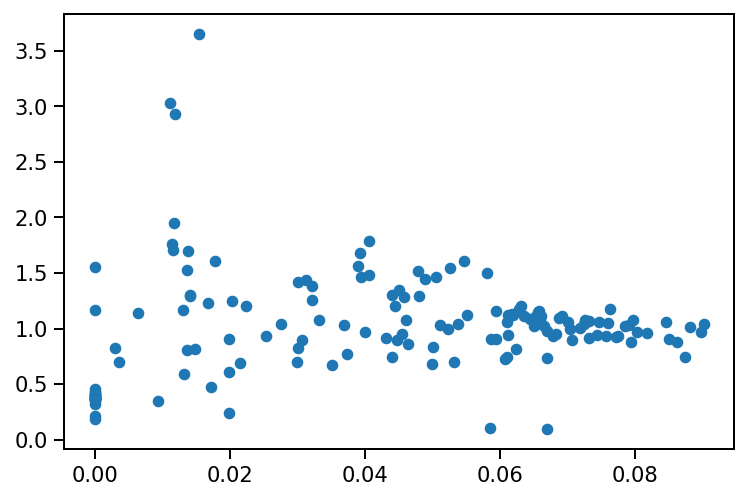

In [12]:
plt.plot(df_merge.amp, df_merge.sigma, 'o')

In [13]:
wl_vacuum = [10833.470120589382, 10833.380094831637, 10832.219762843133]

(-0.5, 0.5)

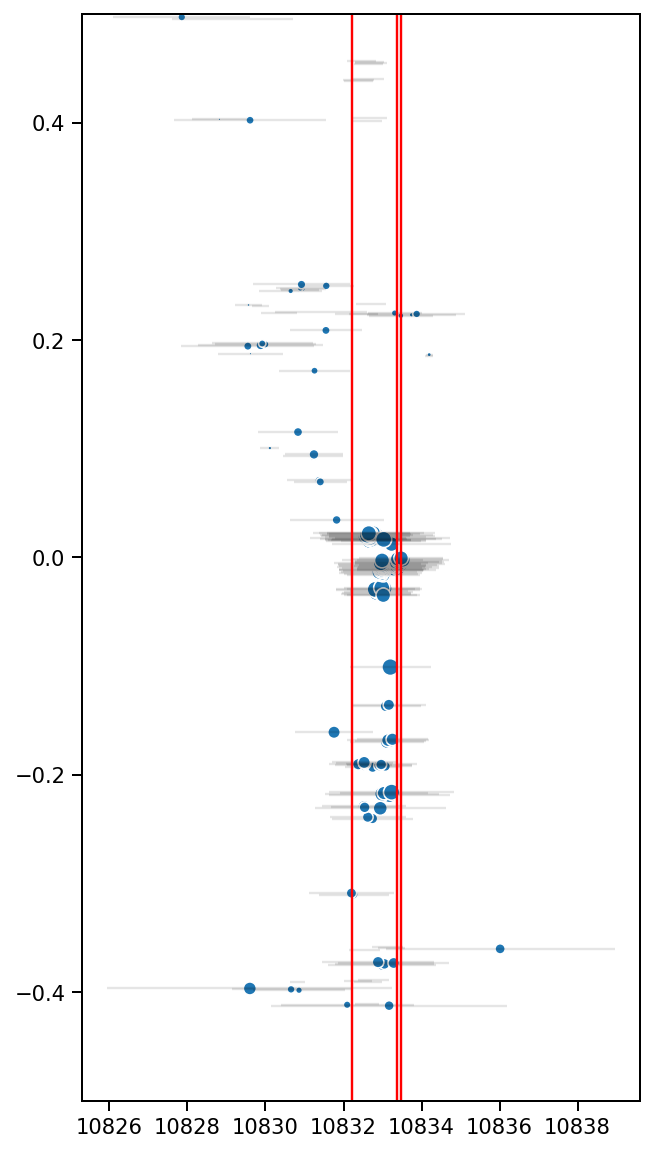

In [14]:
plt.figure(figsize=(5, 10))
plt.scatter(df_merge.lam_0, df_merge['normalized_phase'], ec='w', s=df_merge.auc*300)
plt.errorbar(df_merge.lam_0, df_merge['normalized_phase'], 
             xerr=df_merge.sigma, linestyle='none', color='k', alpha=0.1)
plt.axvline(wl_vacuum[0], color='r')
plt.axvline(wl_vacuum[1], color='r')
plt.axvline(wl_vacuum[2], color='r')

plt.ylim(-0.5, 0.5)

In [15]:
semi_major_axis = 0.06505 * u.AU

planet_speed_quantity = (2*np.pi*semi_major_axis)/(orbital_period*u.day)
planet_speed_quantity.to(u.km/u.second)
planet_speed = planet_speed_quantity.to(u.km/u.second).value

In [16]:
import astropy.constants as const

In [17]:
phase = np.arange(-0.5, 0.5, 0.001)
delta_v_over_c = (planet_speed_quantity/const.c).to(u.dimensionless_unscaled)

In [58]:
wavelength_shift1 =  wl_vacuum[1] + delta_v_over_c * np.sin(2.0*np.pi*phase) * wl_vacuum[1]
wavelength_shift2 =  wl_vacuum[2] + delta_v_over_c * np.sin(2.0*np.pi*phase) * wl_vacuum[2]
wavelength_shift0 =  wl_vacuum[0] + delta_v_over_c * np.sin(2.0*np.pi*phase) * wl_vacuum[0]
wavelength_shiftMed =  10833.4 + delta_v_over_c * np.sin(2.0*np.pi*phase) * 10832.819

In [59]:
df_merge.lam_0_lo.describe()

count    152.000000
mean       0.685292
std        1.261797
min        0.037027
25%        0.057726
50%        0.099512
75%        0.301563
max        4.288799
Name: lam_0_lo, dtype: float64

In [60]:
0.1*4.8*24

11.52

In [61]:
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

In [62]:
(7.062*u.hour/(4.8101*u.day)).to(u.dimensionless_unscaled)/2

<Quantity 0.03058668>

In [63]:
np.median(df_merge.lam_0)

10832.819313909422

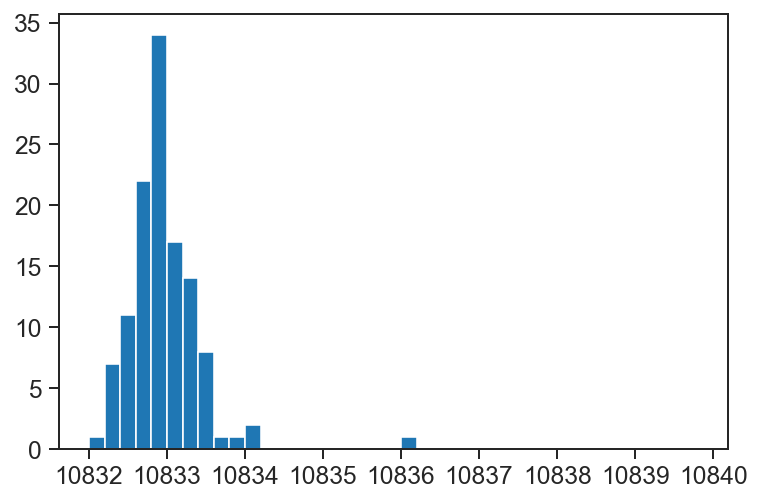

In [64]:
plt.hist(df_merge.lam_0, bins=np.arange(10832, 10840, 0.2));

In [111]:
df_merge.campaign.value_counts()

P4            39
April 2022    34
June 2020     33
May 2020      30
April 2020    16
Name: campaign, dtype: int64

In [125]:
df_merge.campaign.unique()

array(['April 2022', 'April 2020', 'May 2020', 'June 2020', 'P4'],
      dtype=object)

In [126]:
campaigns = ['April 2020', 'May 2020', 'June 2020', 'P4', 'April 2022']

In [129]:
color_dict = {campaign:'C{:1d}'.format(i) for i, campaign in enumerate(campaigns)}

In [130]:
color_dict

{'April 2020': 'C0',
 'May 2020': 'C1',
 'June 2020': 'C2',
 'P4': 'C3',
 'April 2022': 'C4'}

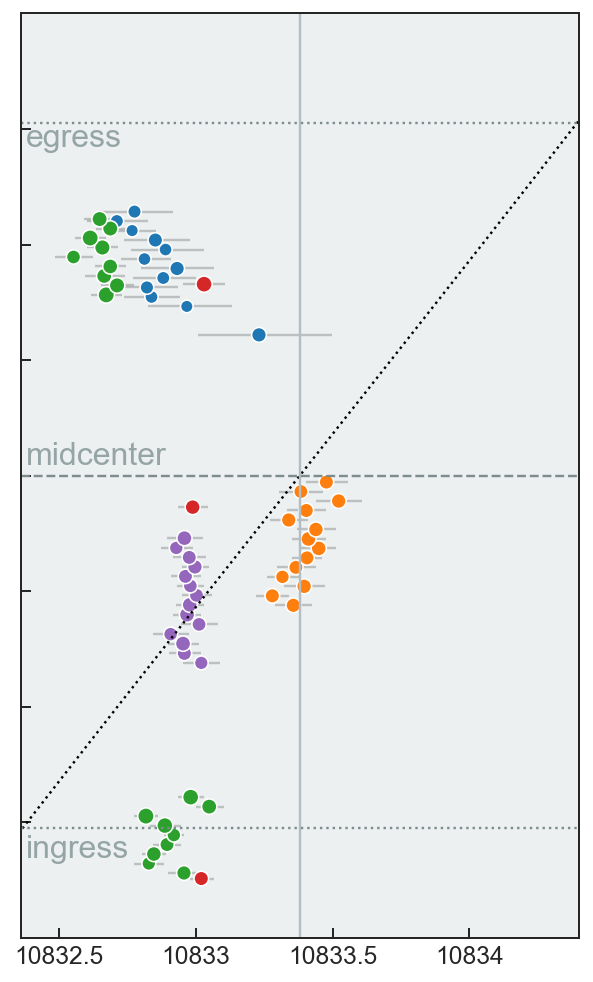

In [220]:
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
fig, ax = plt.subplots(figsize=(5, 8.5))
ax.set_facecolor("#ecf0f1")
for campaign in campaigns:
    mask = df_merge.campaign == campaign
    plt.scatter(df_merge.lam_0[mask], df_merge['normalized_phase'][mask], 
                ec='w', s=df_merge.auc[mask]*300, c=color_dict[campaign],
            label=campaign)
plt.errorbar(df_merge.lam_0, df_merge.normalized_phase, xerr=(df_merge.lam_0_lo, df_merge.lam_0_hi),
             linestyle='none', color='k', alpha=0.2, zorder=-10)


plt.plot(wavelength_shift1, phase, color='k', linestyle='dotted')
#plt.plot(wavelength_shift2, phase, color='k', linestyle='dotted')
#plt.plot(wavelength_shift0, phase, color='k', linestyle='dotted')
#plt.axvline(wl_vacuum[0], color='#b2bec3')
plt.axvline(wl_vacuum[1], color='#b2bec3')
#plt.axvline(wl_vacuum[2], color='#b2bec3')

#plt.plot(wavelength_shiftMed, phase, color='k', linestyle='dotted')
#plt.axvline(10833.4, color='#b2bec3')


#plt.ylabel('Orbital phase, $\phi$')
#plt.xlabel('$\lambda \;$($\AA$)')

plt.xticks([10832.5, 10833, 10833.5, 10834.0])
ax.set_xticklabels([10832.5, 10833, 10833.5, 10834])
#ax.set_xticklabels([])
ax.set_yticklabels([])

plt.axhline(0.0, color='#7f8c8d', linestyle='dashed')
plt.axhline(-0.0305, color='#7f8c8d', linestyle='dotted')
plt.axhline(+0.0305, color='#7f8c8d', linestyle='dotted')
plt.text(10832.38, +0.0285, 'egress', color='#95a5a6', size=16, weight='light')
plt.text(10832.38, +0.001, 'midcenter', color='#95a5a6', size=16, weight='light')
plt.text(10832.38, -0.033, 'ingress', color='#95a5a6', size=16, weight='light')


plt.ylim(-0.04, 0.04)
plt.xlim(10832.36, 10834.4)
#plt.legend(frameon=False, loc='upper right', ncol=1);
plt.savefig('../../paper/paper1/figures/centroid_inset10833.png', bbox_inches='tight', dpi=300)

In [150]:
from matplotlib import patches

In [ ]:
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

(array([25., 16., 71., 24., 12.,  1.,  0.,  1.,  1.,  1.]),
 array([0.22231758, 1.06025   , 1.89818242, 2.73611484, 3.57404725,
        4.41197967, 5.24991209, 6.08784451, 6.92577693, 7.76370935,
        8.60164177]),
 <BarContainer object of 10 artists>)

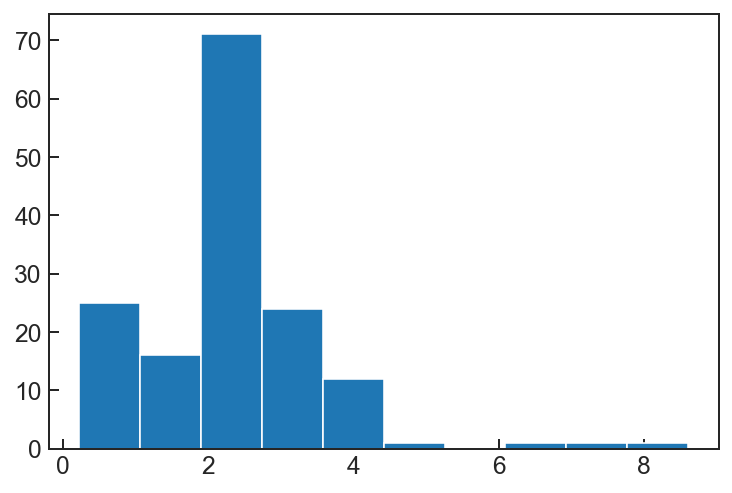

In [219]:
plt.hist(df_merge.sigma*2.355)

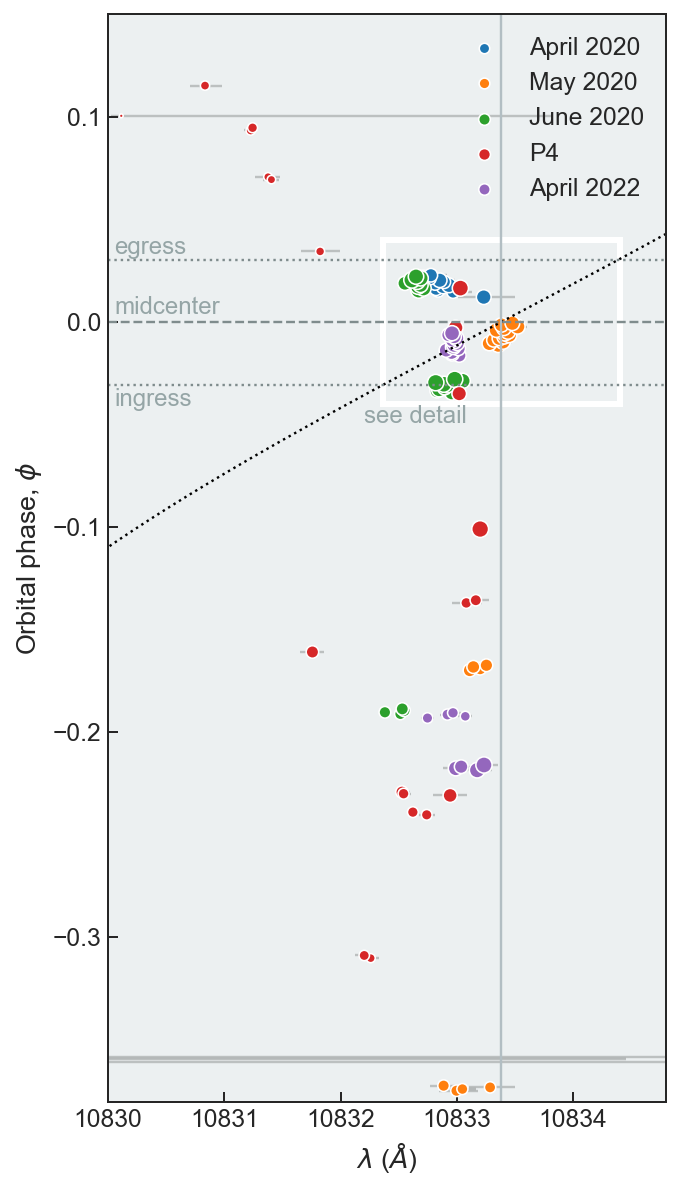

In [217]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.set_facecolor("#ecf0f1")
for campaign in campaigns:
    mask = df_merge.campaign == campaign
    plt.scatter(df_merge.lam_0[mask], df_merge['normalized_phase'][mask], 
                ec='w', s=df_merge.auc[mask]*300, c=color_dict[campaign],
            label=campaign)
plt.errorbar(df_merge.lam_0, df_merge.normalized_phase, xerr=(df_merge.lam_0_lo, df_merge.lam_0_hi),
             linestyle='none', color='k', alpha=0.2, zorder=-10)

plt.plot(wavelength_shift1, phase, color='k', linestyle='dotted')
#plt.plot(wavelength_shift2, phase, color='k', linestyle='dotted')
#plt.plot(wavelength_shift0, phase, color='k', linestyle='dotted')
#plt.axvline(wl_vacuum[0], color='#b2bec3')
plt.axvline(wl_vacuum[1], color='#b2bec3')
#plt.axvline(wl_vacuum[2], color='#b2bec3')

#plt.plot(wavelength_shiftMed, phase, color='k', linestyle='dotted')
#plt.axvline(10833.4, color='#b2bec3')


plt.ylabel('Orbital phase, $\phi$')
plt.xlabel('$\lambda \;$($\AA$)')

plt.xticks([10830, 10831, 10832, 10833, 10834])
ax.set_xticklabels([10830, 10831, 10832, 10833, 10834])

plt.axhline(0.0, color='#7f8c8d', linestyle='dashed')
plt.axhline(-0.0305, color='#7f8c8d', linestyle='dotted')
plt.axhline(+0.0305, color='#7f8c8d', linestyle='dotted')
plt.text(10830.05, +0.033, 'egress', color='#95a5a6', size=12, weight='light')
plt.text(10830.05, +0.004, 'midcenter', color='#95a5a6', size=12, weight='light')
plt.text(10830.05, -0.041, 'ingress', color='#95a5a6', size=12, weight='light')
plt.text(10832.2, -0.049, 'see detail', color='#95a5a6', size=12, weight='light')

ax.add_patch(
     patches.Rectangle(
        (10832.36, -0.04),
        10834.4-10832.36,
        0.04+0.04,
        fill=False, lw=3
     ) ) 


plt.ylim(-0.38, 0.15)
plt.xlim(10830, 10834.8)
plt.legend(frameon=False, loc='upper right', ncol=1);
plt.savefig('../../paper/paper1/figures/centroid_overview10833.png', bbox_inches='tight', dpi=300)

(-0.5, 0.5)

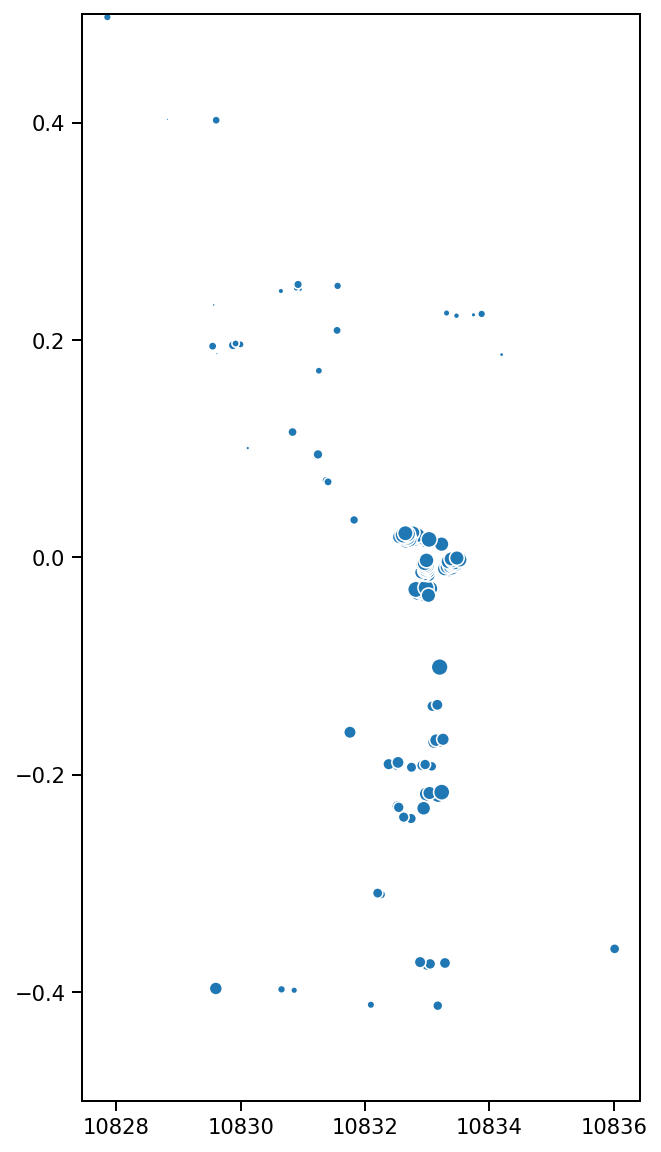

In [22]:
plt.figure(figsize=(5, 10))
plt.scatter(df_merge.lam_0, df_merge['normalized_phase'], ec='w', s=df_merge.auc*300)
plt.ylim(-0.5, 0.5)

What is the velocity distribution of the gas?

In [23]:
v_blueshift = ((df_merge.lam_0.values-wl_vacuum[1])/wl_vacuum[1]*const.c).to(u.km/u.s)

(-150.0, 150.0)

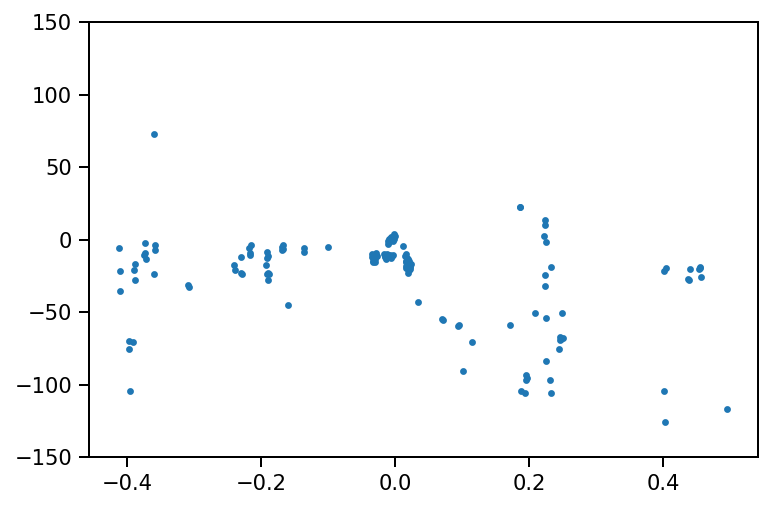

In [24]:
plt.plot(df_merge['normalized_phase'], v_blueshift, '.')
plt.ylim(-150, 150)

In [135]:
v_los = (df_merge.sigma.values*2.355/10833*const.c).to(u.km/u.s)

In [105]:
v_los

<Quantity [ 45.84236742,  44.30855191,  54.30304178,  59.64753654,
            99.23950041,  67.17892717,  83.70569241,  84.3750824 ,
            96.45518202, 116.53676046,  84.66653988,  95.48464426,
            94.28980655,  78.25563494,  88.0976046 , 102.1053336 ,
            23.83242362,  27.94917764,  30.01962266,  76.26836986,
            90.21427614,  82.16363048,  92.60736865,  93.74441162,
            61.5375973 ,  59.34892267,  68.11012986,  58.98269671,
            65.55689197,  60.21589569,  68.76221816,  62.2122413 ,
            70.68189223,  65.06107116,  75.58010064,  72.56252913,
            74.76413192,  72.73735146,  72.34528466,  76.89476768,
            75.57775325,  70.24405494,  52.56124553,  31.07218103,
            38.72976443,  39.88824623,  23.69538679,  26.74023845,
            23.95972358,  23.68463396,  76.07078067,  99.41071487,
           238.04184707,  47.63564756,  48.62072417,  47.70750092,
            53.04369281,  61.04085401,  58.68591639,  57.57223

In [134]:
0.8*2.355, 1.1*2.355

(1.8840000000000001, 2.5905)

(0.0, 2.0)

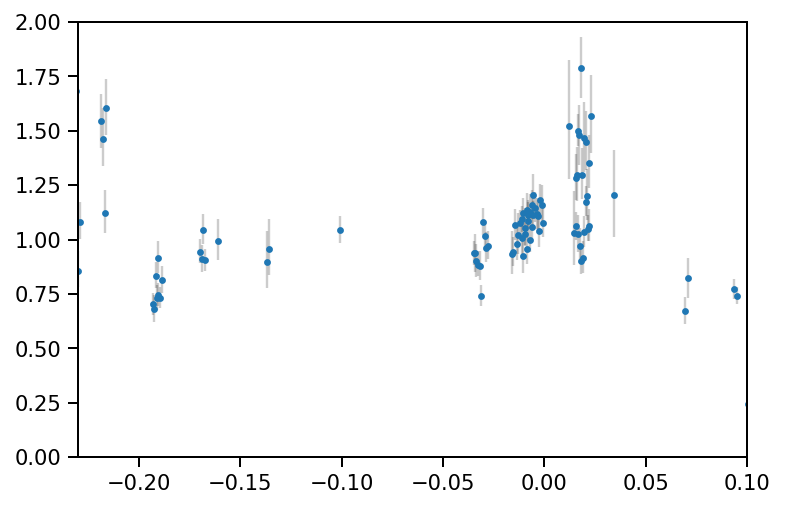

In [159]:
plt.plot(df_merge['normalized_phase'], df_merge.sigma, '.')
plt.errorbar(df_merge.normalized_phase, df_merge.sigma, yerr=(df_merge.sigma_lo, df_merge.sigma_hi),
             linestyle='none', color='k', alpha=0.2, zorder=-10)
plt.xlim(-0.23, 0.1)
plt.ylim(0.0, 2)

(0.0, 150.0)

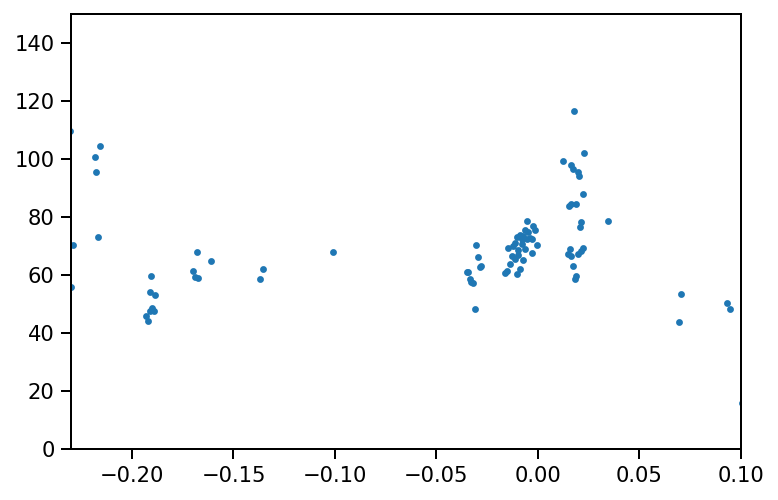

In [160]:
plt.plot(df_merge['normalized_phase'], v_los, '.')
plt.xlim(-0.23, 0.1)
plt.ylim(0.0, 150)

In [162]:
mask = (df_merge['normalized_phase'] < 0.033) & (df_merge['normalized_phase'] > -0.033)

Text(0, 0.5, '$v_{los}$ (km/s)')

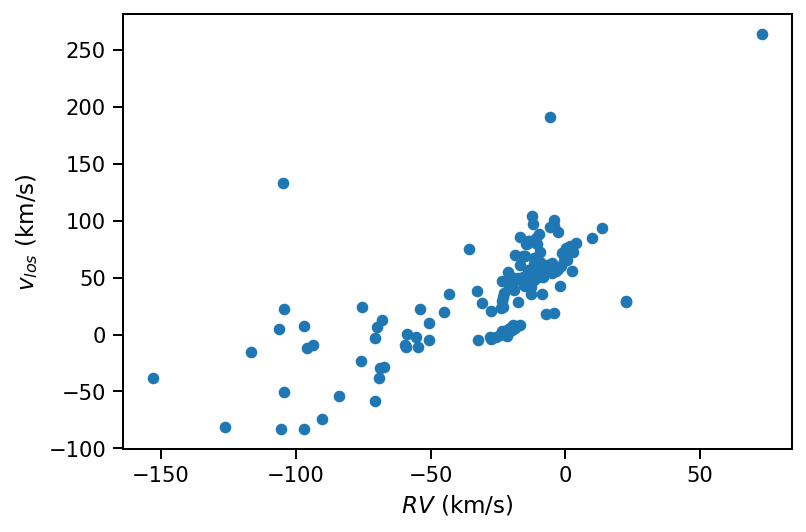

In [171]:
plt.plot(v_blueshift, v_los+v_blueshift, 'o')
plt.xlabel('$RV$ (km/s)')
plt.ylabel('$v_{los}$ (km/s)')

Look at a draw from the sampler:

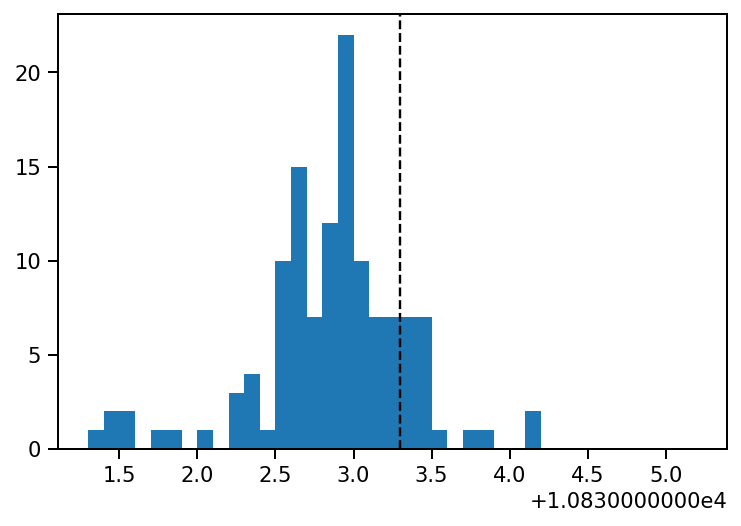

In [75]:
plt.hist(df_out.lam_0, 
         bins=np.arange(10833.30-2, 10833.30+2, 0.1));
plt.axvline(10833.30, color='k', linestyle='dashed')

In [173]:
rate = (150.0 * u.km/u.s)

In [174]:
distance = rate * 1.0*u.day

In [175]:
a_AU = 0.065*u.AU

In [176]:
extent = 0.2*2*np.pi*a_AU

In [177]:
(distance/extent).to(u.dimensionless_unscaled)

<Quantity 1.06061159>

(10832.699999999999, 10834.1)

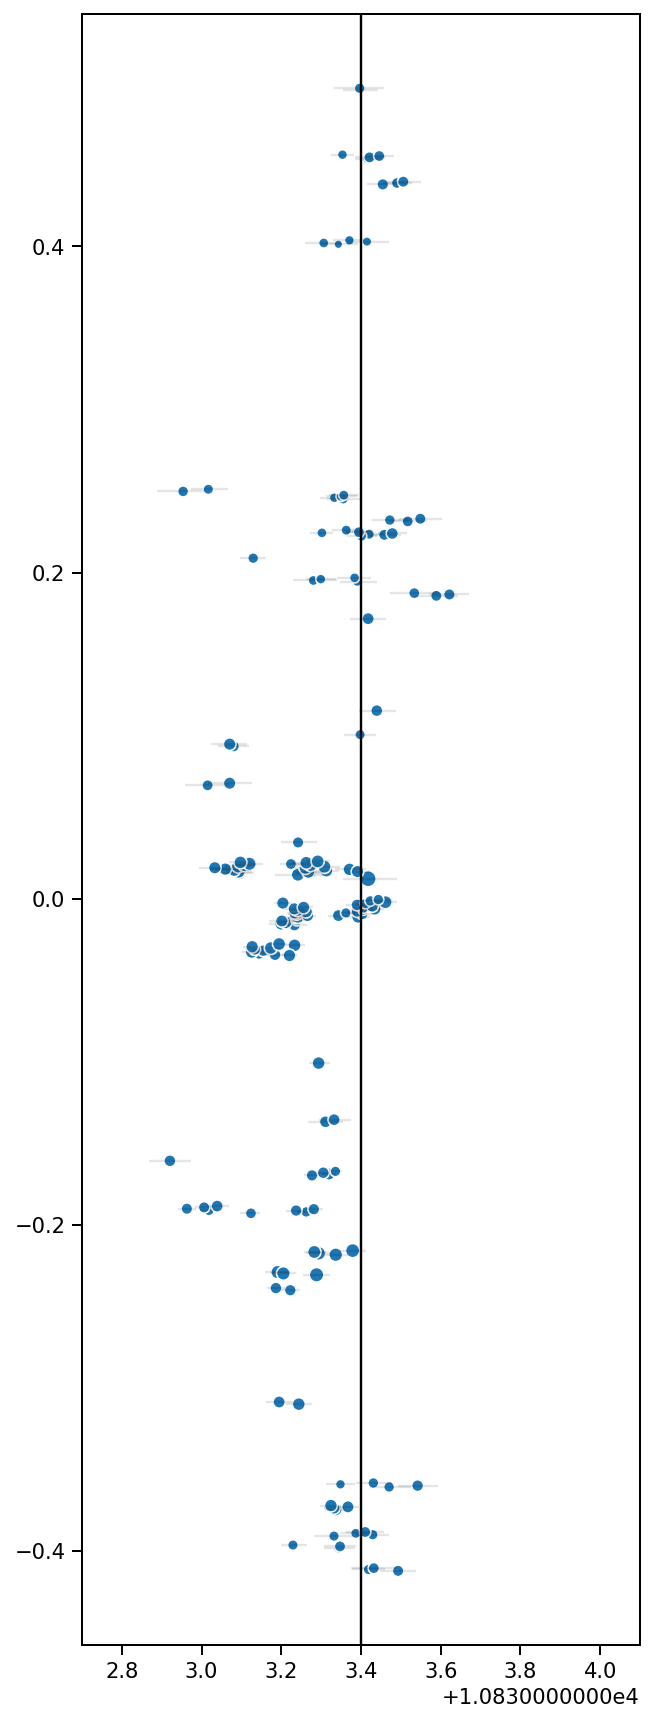

In [118]:
plt.figure(figsize=(5, 15))
plt.errorbar(df_out.lam2, df.normalized_phase, xerr=(df_out.lam2_lo, df_out.lam2_hi),
             linestyle='none', color='k', alpha=0.1)
plt.scatter(df_out.lam2, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10833.4-0.7, 10833.4+0.7)

In [102]:
import astropy.constants as const

In [107]:
velocities = (df_out.lam2-10833.4).values/10833.4 * const.c.to(u.km/u.s)

(-20.0, 20.0)

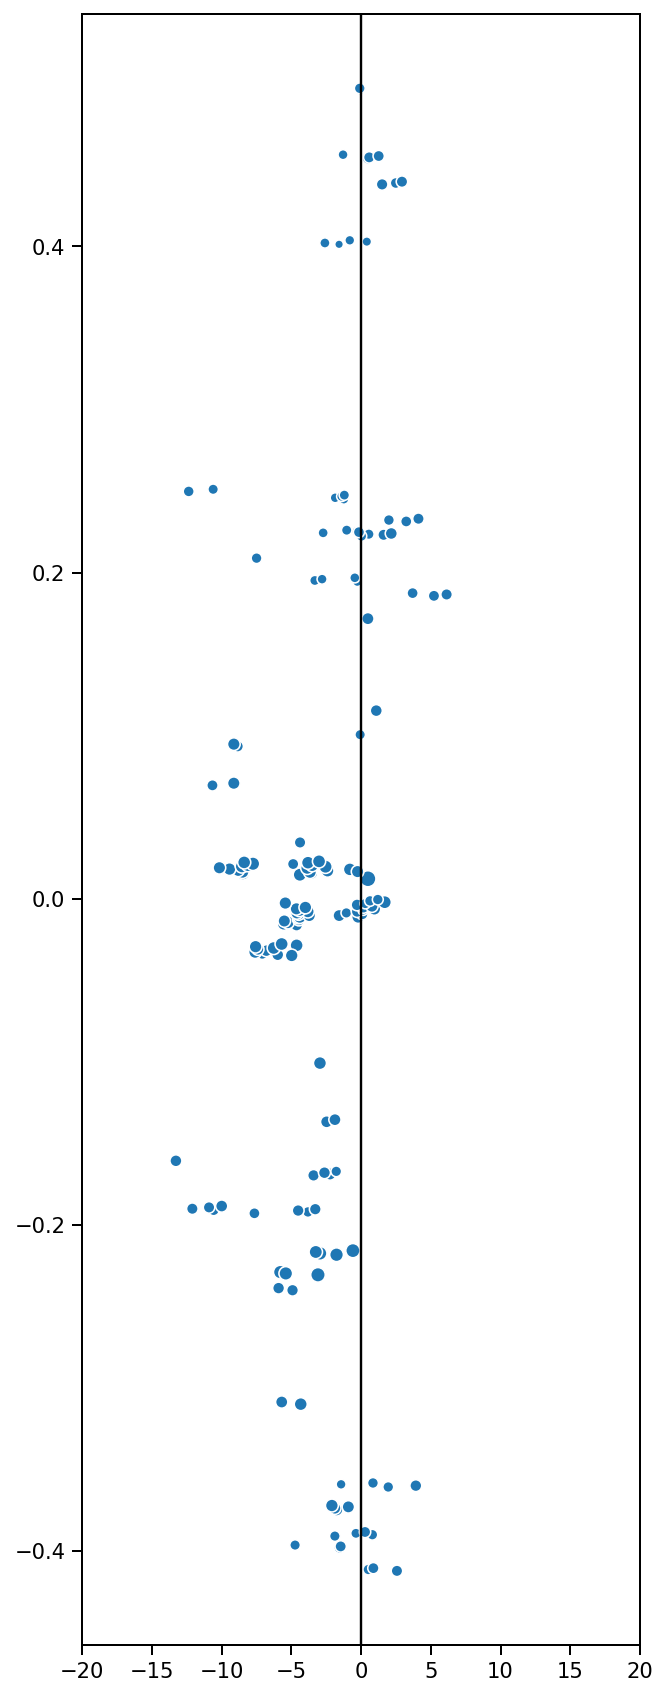

In [116]:
plt.figure(figsize=(5, 15))
plt.scatter(velocities, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(0, color='k')
plt.xlim(-20, 20)

(10829.0, 10834.0)

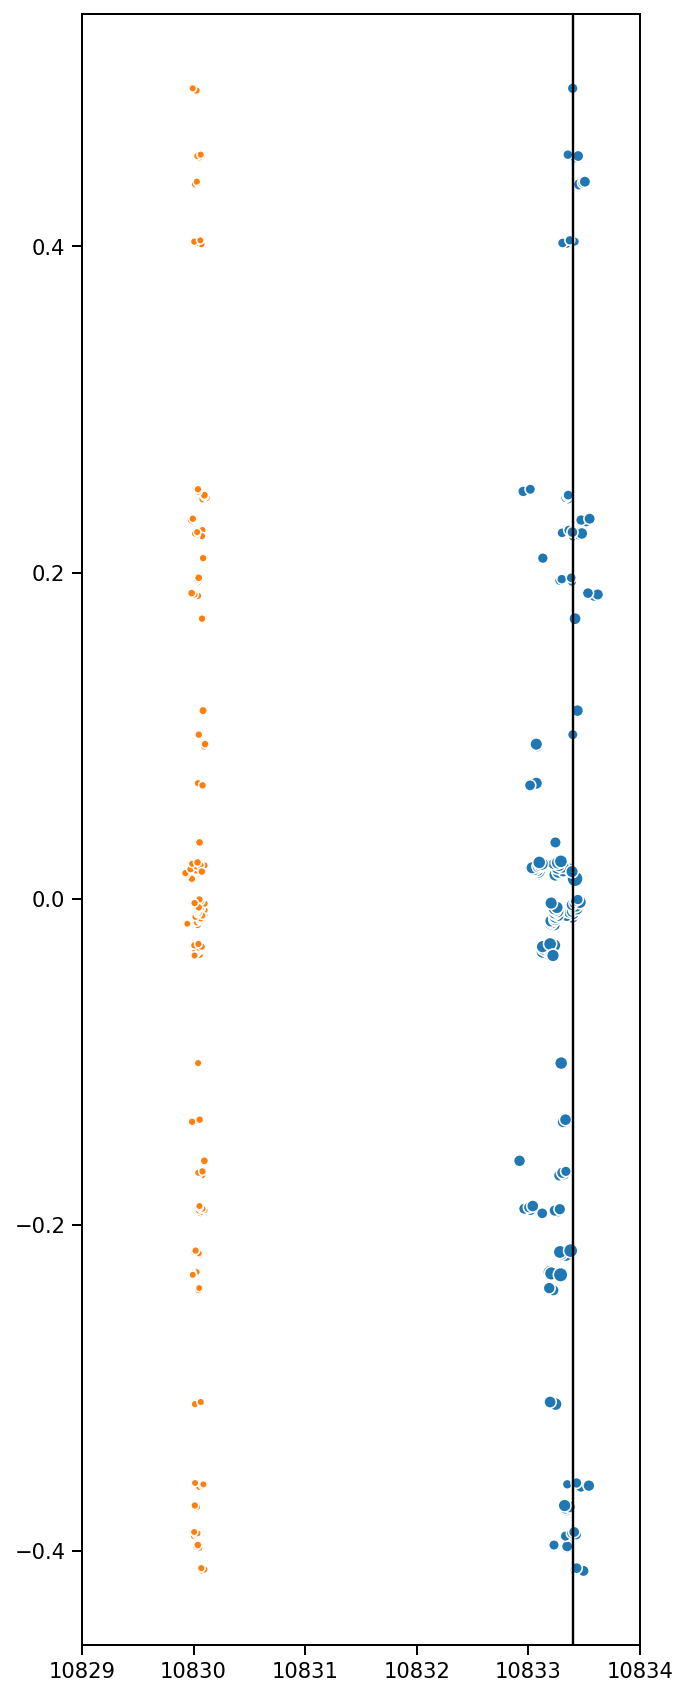

In [52]:
plt.figure(figsize=(5, 15))
plt.scatter(df.center_wl, df.normalized_phase, s=df_out.amp2*50, ec='w')
plt.scatter(df_out.lam1, df.normalized_phase, s=df_out.amp1*50, ec='w')

#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10829, 10834)

Re-initialize to the a draw from the first trial to shed some hysteresis of the first coarse initialization.

In [40]:
samples = sampler.get_chain()

p0 = samples[-1, 13, :] + perturbations.T

In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob)
output = sampler.run_mcmc(p0, 5000, progress=True)

100%|██████████████████████████████████████| 5000/5000 [00:31<00:00, 160.56it/s]


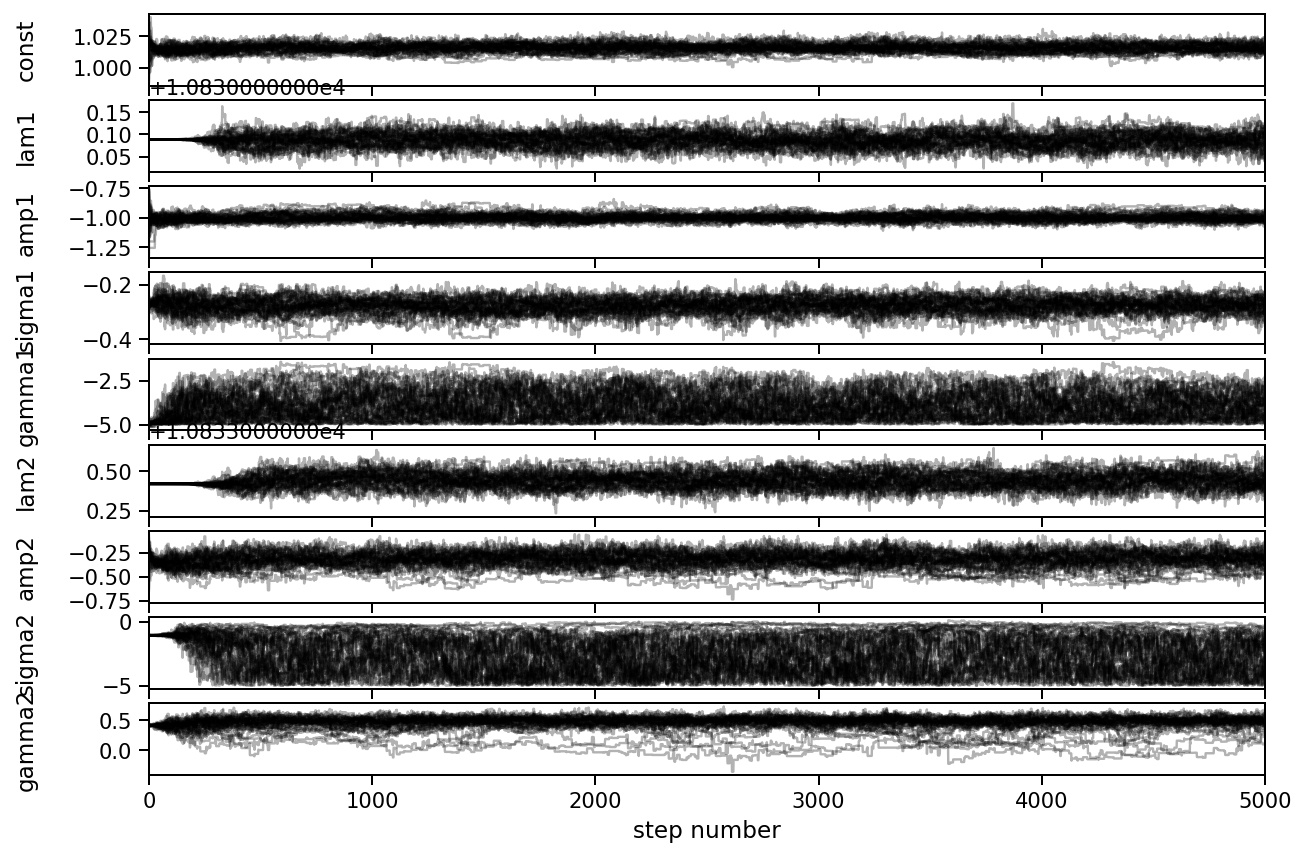

In [42]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [43]:
samples_absolute = transform_samples(samples)

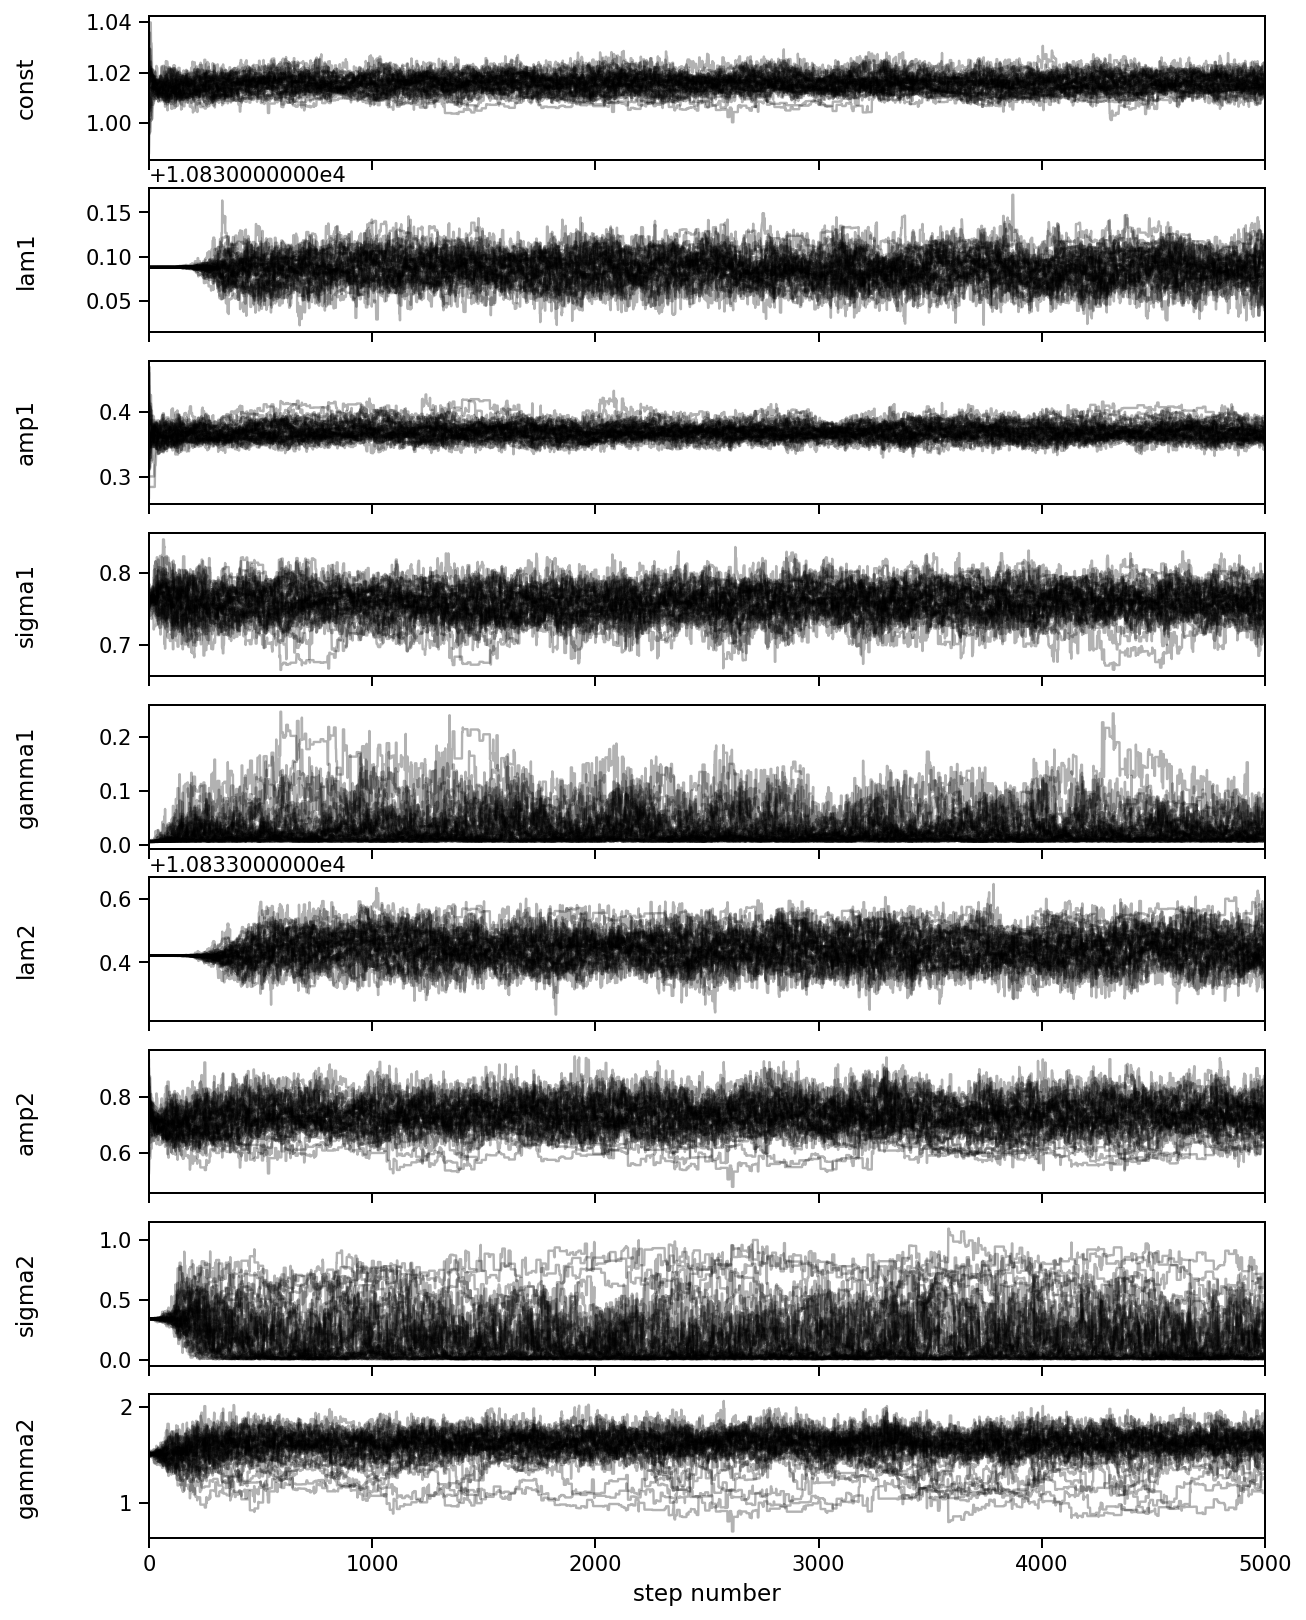

In [44]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_absolute[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_absolute))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(10827.0, 10838.0)

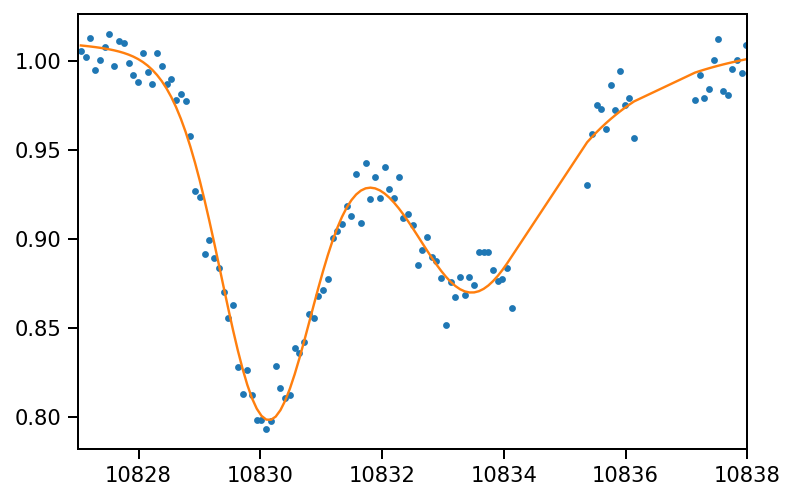

In [45]:
flux_model = joint_model(samples[-1, 13, :], wavelength=spec.wavelength.value) 

plt.plot(spec.wavelength.value, spec.flux.value, '.')
plt.plot(spec.wavelength.value, flux_model)
plt.xlim(10827, 10838)

Ok, good enough for our purposes!